In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as scs
import scipy.integrate
from scipy.interpolate import CubicSpline
import scipy.spatial.transform as sst
import functools
import copy

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
class CUBE(object):
  def __init__(self, fname):
    f = open(fname, 'r')
    for i in range(2): f.readline() # echo comment
    tkns = f.readline().split() # number of atoms included in the file followed by the position of the origin of the volumetric data
    self.natoms = int(tkns[0])
    self.origin = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NX = int(tkns[0])
    self.X = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NY = int(tkns[0])
    self.Y = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NZ = int(tkns[0])
    self.Z = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    self.atoms = []
    for i in range(self.natoms):
      tkns = f.readline().split()
      self.atoms.append([tkns[0], tkns[2], tkns[3], tkns[4]])
    self.data = np.zeros((self.NX,self.NY,self.NZ))
    i=0
    for s in f:
      for v in s.split():
        self.data[i//(self.NY*self.NZ), (i//self.NZ)%self.NY, i%self.NZ] = float(v)
        i+=1
    if i != self.NX*self.NY*self.NZ: raise NameError("FSCK!")


In [3]:
@functools.lru_cache(120)
def read_qs(folder):
    cube = CUBE('%s/DENSITY.cube' % folder)
    return cube
    #cube = CUBE('data/CO-2/box-12/%s/DENSITY.cube' % folder)
    return cube.data

In [4]:
def get_deriv(basedir, loc, site):
    if loc != '1.0':
        up = read_qs('%s/lval-%s00000-%s-up' %(basedir, loc, site))
    else:
        up = read_qs('%s/lval-1.000000' % basedir)
    if loc != '0.0':
        dn = read_qs('%s/lval-%s00000-%s-dn'% (basedir, loc, site))
    else:
        dn = read_qs('%s/lval-0.000000' % basedir)
    if loc in '0.0 1.0'.split():
        delta = 0.005
    else:
        delta = 0.01
    return (up.data-dn.data)/delta    

def get_total(basedir, site):
    lvals = []
    ds = []
    for mval in '0.0 0.2 0.4 0.6 0.8 1.0'.split():
        tmp = get_deriv(basedir, mval, site)
        #plt.plot(tmp.sum(axis=1).sum(axis=1))
        #plt.axvline(81)
        #plt.axvline(99)
        #plt.show()
        ds.append(tmp.ravel())
        lvals.append(float(mval))
    #total = scipy.integrate.simps(ds, lvals, axis=0)
    total = np.trapz(ds, lvals, axis=0)
    return total.reshape(tmp.shape)

tr = read_qs('data-density/coo/box-15/lval-0.000000').data
tf = read_qs('data-density/coo/box-15/lval-1.000000').data
tc= get_total('data-density/coo/box-15/', 'C')
to= get_total('data-density/coo/box-15/', 'O')
ta= get_total('data-density/coo/box-15/', 'A')

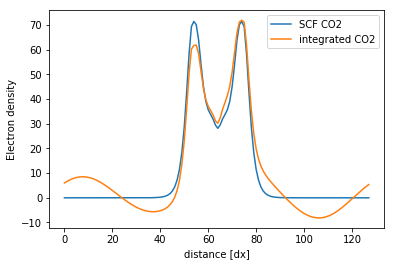

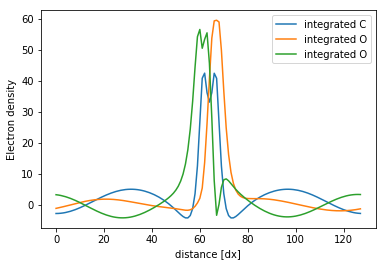

In [5]:
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')

plt.plot(tf.sum(axis=0).sum(axis=1), label='SCF CO2')
plt.plot((tr+tc+to+ta).sum(axis=0).sum(axis=1), label='integrated CO2')
plt.legend()

plt.show()
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')
plt.plot((tc+tr/3).sum(axis=1).sum(axis=1), label='integrated C')
plt.plot((to+tr/3).sum(axis=1).sum(axis=1), label='integrated O')
plt.plot((ta+tr/3).sum(axis=1).sum(axis=1), label='integrated O')
plt.legend()

NameError: name 'yss' is not defined

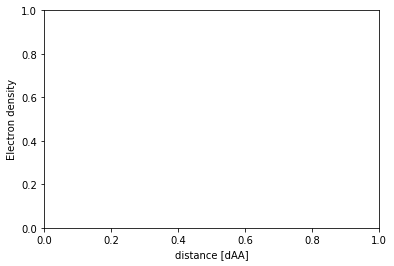

In [6]:
cube = CUBE('data-density/coo/box-15/lval-1.000000/DENSITY.cube')
plt.ylabel('Electron density')
plt.xlabel('distance [dAA]')
ys = (to+tr/3).sum(axis=1).sum(axis=1)
xs = np.linspace(0, len(ys)*cube.X[0], len(ys))
plt.plot(xs, ys-yss, label='integrated C')
plt.plot(xs, ys, label='integrated C')
#plt.plot(xs, yss)
plt.legend()

In [ ]:
amplitude = ys[0]
periods = 2
yss = amplitude*np.sin(np.pi/2+2*np.pi*periods/len(ys)*np.linspace(0, len(ys), len(ys)))
plt.plot(xs, yss)


In [ ]:
fd = np.fft.rfft(ys)
#fd[:3] = 0.
#fd[4:] = 0.
#fd[2] = 300.
plt.plot(np.fft.irfft(fd))
plt.plot(ys)

In [5]:
def fourier_filter(ts):
    fys = np.fft.rfft(ts)
    fys[2] = -(fys[1]+fys[3])/2
    return np.fft.irfft(fys)
    
#factor = [8, 8, 6]
#combination = []
#for qidx, q in enumerate((ta, to, tc)):
#    ys = (q+tr * factor[qidx] / sum(factor)).sum(axis=0).sum(axis=1)
#    ys = (q).sum(axis=0).sum(axis=1)
#    
#    #fys[2] = np.sign(fys[2]) * (abs(fys[1])+abs(fys[3]))/2
#    
#    combination.append(ys2)
#    #plt.plot(fys[:10], 'o-')
#    plt.plot(xs, ys2)
#plt.xlim(10, 20)

In [ ]:
plt.plot((tf).sum(axis=0).sum(axis=1))
plt.plot(combination[0] + combination[1]+combination[2] + (tr).sum(axis=0).sum(axis=1))
plt.plot((tr+tc+to+ta).sum(axis=0).sum(axis=1))

In [64]:
weightlookup = {'O': 8, 'C': 6, 'A': 8}
@functools.lru_cache(120)
def get_projected(basedir, axes, sites):
    cube = read_qs(basedir + '/lval-1.000000')
    actual = cube.data.sum(axis=axes[0]).sum(axis=axes[1])
    reference = read_qs(basedir + '/lval-0.000000').data.sum(axis=axes[0]).sum(axis=axes[1])
    
    partials = []
    derivatives = []
    for site in sites:
        tderivatives = []
        lvals = []
        ds = []
        for mval in '0.0 0.2 0.4 0.6 0.8 1.0'.split():
            tmp = get_deriv(basedir, mval, site)
            tderivatives.append(tmp.sum(axis=axes[0]).sum(axis=axes[1]))
            ds.append(tmp.ravel())
            lvals.append(float(mval))
        total = np.trapz(ds, lvals, axis=0)
        ts = total.reshape(tmp.shape).sum(axis=axes[0]).sum(axis=axes[1])
        partials.append(ts)
        derivatives.append(tderivatives)
    
    # symmetrize
    origpartials = partials[::]
    if len(sites) == 3:
        partials = [((partials[0]+partials[1][::-1])/2), ((partials[1]+partials[0][::-1])/2), partials[2]]
    
    return cube.X[0], cube.Y[1], cube.Z[2], actual, partials, derivatives, reference, cube.atoms, origpartials

In [65]:
def plot_cubes(ax, shift, scale, mol, sites):
    if len(sites) == 3:
        elementcolor = {1: 'C4', 3: 'C4', 2: 'C2'}
    else:
        elementcolor = {1: 'C2', 2: 'C4'}
    for sidx, site in enumerate(sites):
        cube1 = CUBE('cp2k-dens/n2/%s/up-%d/CO-long-ELECTRON_DENSITY-1_0.cube' % (mol, site))
        cube2 = CUBE('cp2k-dens/n2/%s/dn-%d/CO-long-ELECTRON_DENSITY-1_0.cube' % (mol, site))
        xs = np.linspace(0, cube1.X[0]*(1+cube1.NX),cube1.NX)
        ys = (cube1.data - cube2.data).sum(axis=1).sum(axis=0)
        xss = np.linspace(min(xs), max(xs), 500)
        yss = CubicSpline(xs, ys)(xss)
        print (mol, site, site-1)
        ax.plot((xss-shift),scale*yss, '--', color=elementcolor[site])
#plot_cubes('co-long', (2, 1), 7, 15)

co2 1 0
co2 3 2
co2 2 1
co-long 2 1
co-long 1 0
co-short 2 1
co-short 1 0


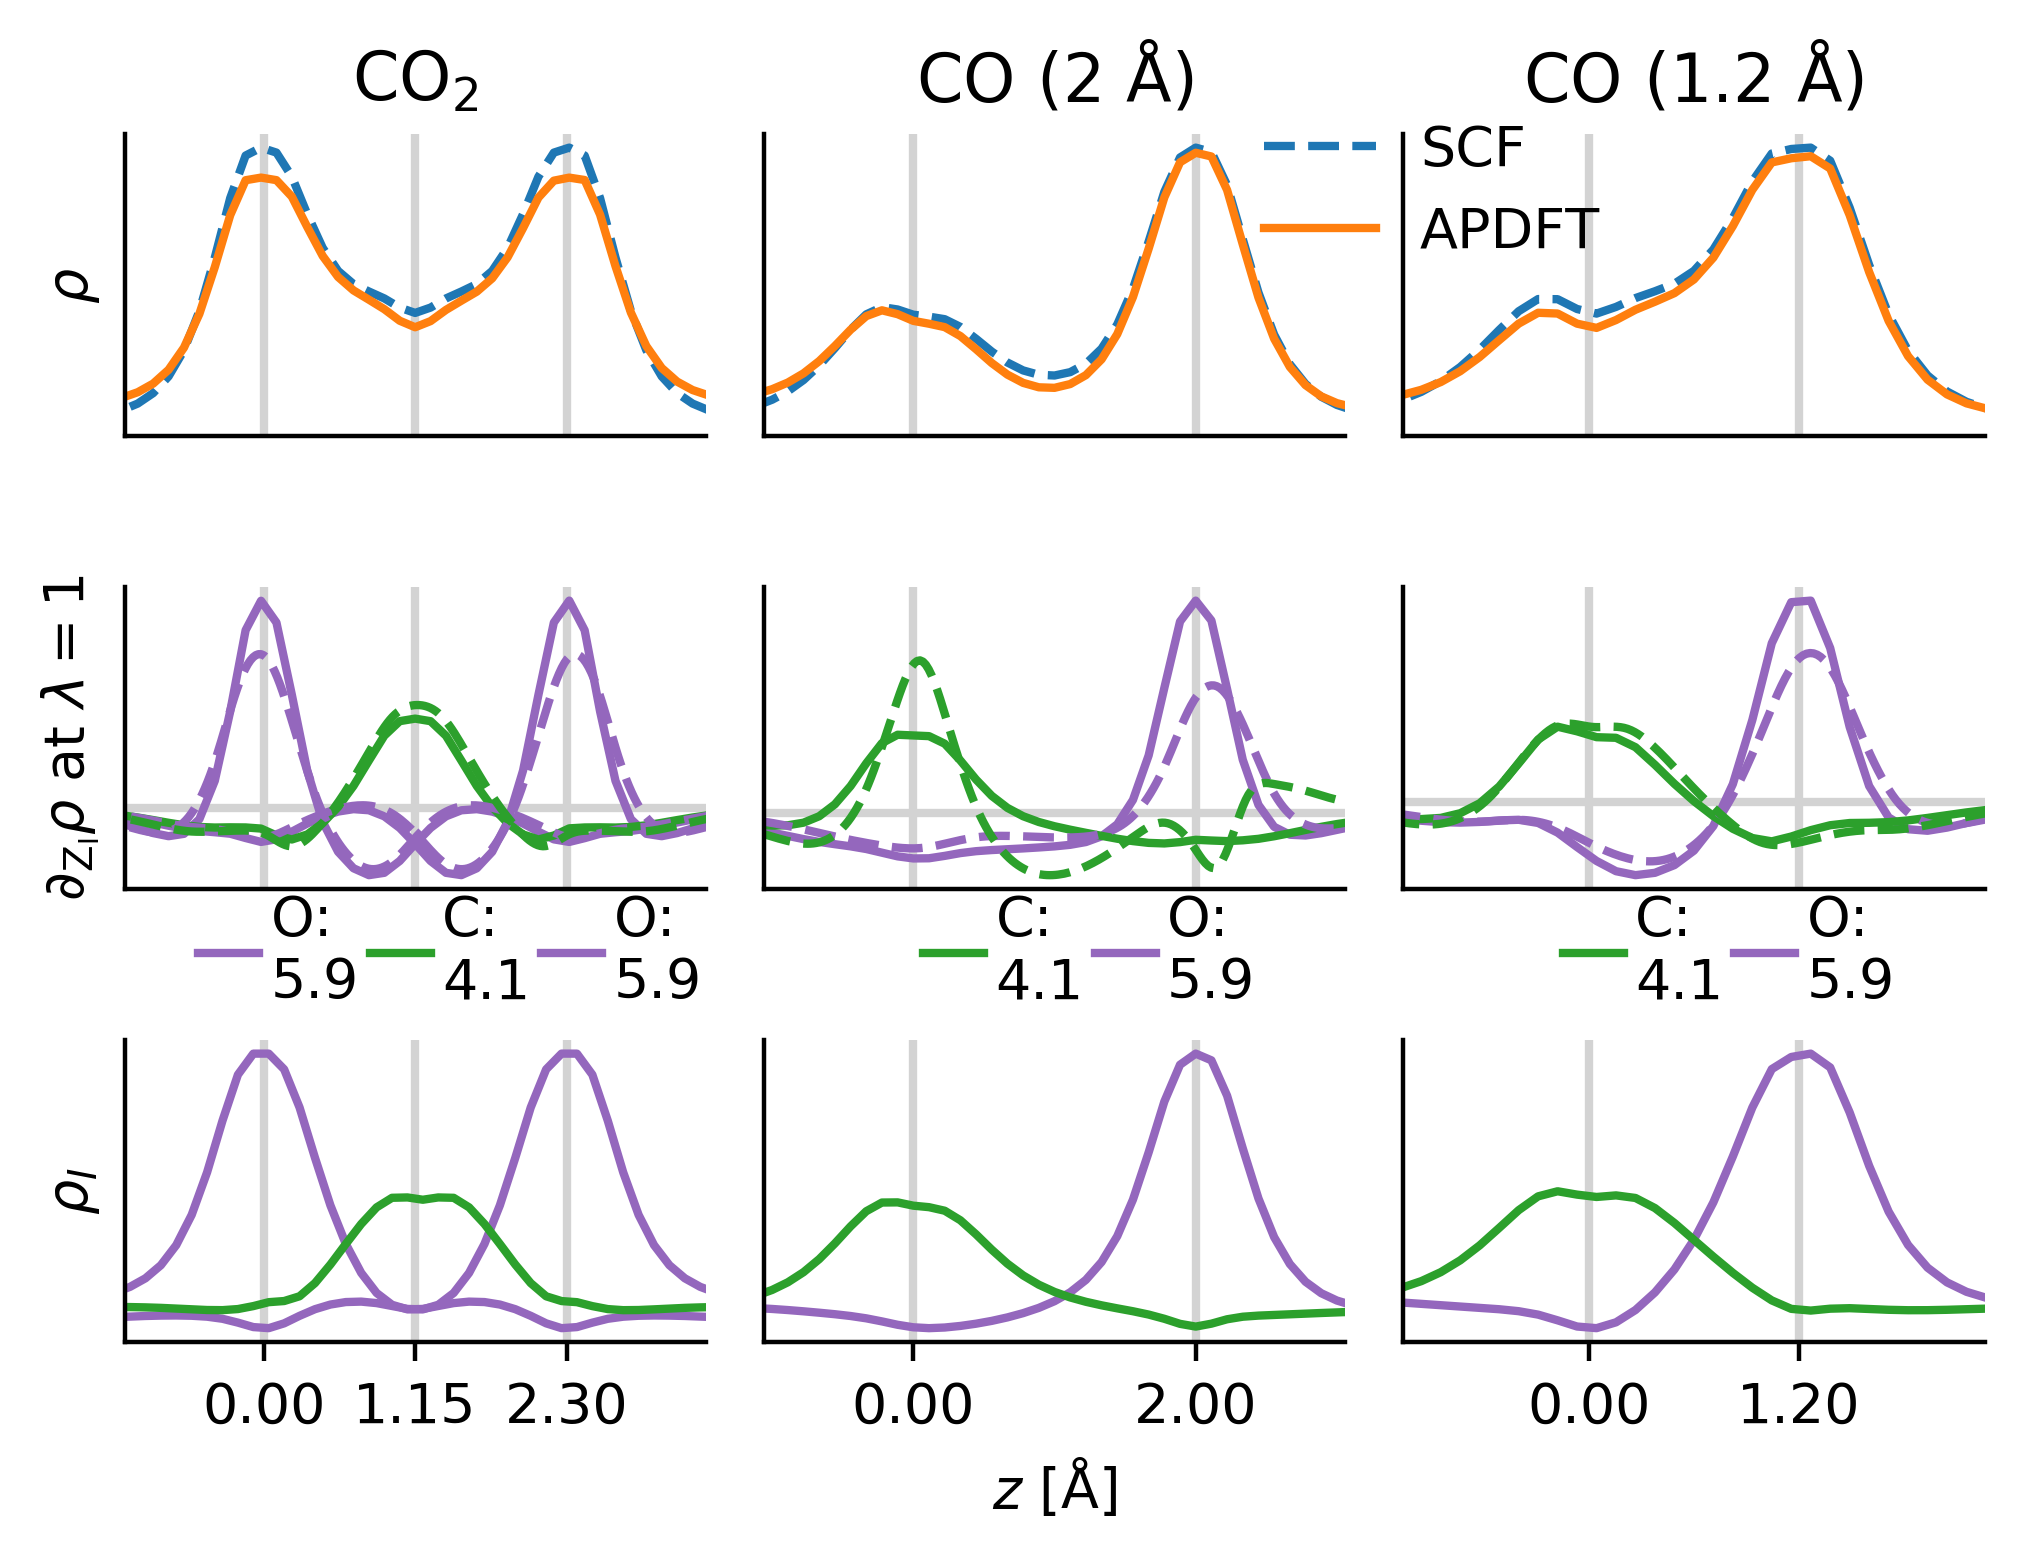

In [66]:
def density_figure():
    f, axs = plt.subplots(3, 3, dpi=400)
    
    def _plot_setup(basepath, projectionaxes, axes, sites, dim, totalelectrons, correctfn, responseshift, responsescale, responsefolder, responsesites):
        axtotal, axderiv, axdecomp = axes
        dx, dy, dz, actual, partials, derivatives, reference, atoms, origpartials = get_projected(basepath, projectionaxes, sites)
        actual, partials, derivatives, reference = copy.copy(actual), copy.copy(partials), copy.copy(derivatives), copy.copy(reference)
        xs = np.linspace(0, len(actual)*dx, len(actual)+1)[:-1]
        
        # total plot
        axtotal.plot(xs, actual, '--', label='SCF')
        axtotal.plot(xs, fourier_filter(np.sum(origpartials, axis=0))+reference, label='APDFT')
        if basepath == 'data-density/CO-1.2/box-20/':
            axtotal.legend(frameon=True, bbox_to_anchor=(-0.45, 2.2, 1, 1.), loc='upper center')
        
        # contributions
        cutoff = 30
        fpartials = [correctfn(_) for _ in partials]
        totalweight = np.sum(np.sum(fpartials, axis=0)[:cutoff]) + np.sum(np.sum(fpartials, axis=0)[-cutoff:])
        decomp_handles = []
        decomp_labels = []
        elementcolor = {'C': 'C2', 'O': 'C4'}
        for sidx, site in enumerate(sites):
            ys = fpartials[sidx]
            #ys *= int(atoms[sidx][0])
            ys += (np.sum(fpartials[sidx][:cutoff])+np.sum(fpartials[sidx][-cutoff:]))/totalweight*reference
            siteelectrons = np.sum(ys)/np.sum(actual)*totalelectrons
            element = site
            if element == 'A':
                element = 'O'
            decomp_labels.append( '%s:\n%1.1f' % (element, siteelectrons))
            if len(sites) == 3:
                xshift = (xs[1]-xs[0])/2
            else:
                xshift = 0
            _, = axdecomp.plot(xs+xshift, ys, color=elementcolor[element])
            decomp_handles.append(_)
        if len(decomp_handles) == 2:
            decomp_handles = decomp_handles[::-1]
            decomp_labels = decomp_labels[::-1]
        else:
            decomp_handles = [decomp_handles[_] for _ in (0, 2, 1)]
            decomp_labels = [decomp_labels[_] for _ in (0, 2, 1)]
        axdecomp.legend(decomp_handles, decomp_labels, frameon=False, bbox_to_anchor=(-0.04, 0.65, 1.2, 1), loc='upper center',ncol=3,handlelength=1.1,handletextpad=0.2,columnspacing=0.2)
        
        # responses
        for sidx, site in enumerate(sites):
            element = site
            if element == 'A':
                element = 'O'
            axderiv.plot(xs, correctfn(derivatives[sidx][5]), color=elementcolor[element])
        axderiv.axhline(0, zorder=-10, color='lightgrey')
        plot_cubes(axderiv, responseshift, responsescale,  responsefolder, responsesites)
        if basepath == 'data-density/CO-1.2/box-20/':
            axtotal.legend(frameon=False, bbox_to_anchor=(-0.45, 0.2, 1, 1), loc='upper center')
        
        # vertical lines
        pos = np.array(atoms)[:, dim].astype(float)
        #print (basepath, pos)
        for ax in axes:
            for p in pos:
                ax.axvline(p, zorder=-10, color='lightgrey')
        
        axtotal.set_xlim(min(pos)-2, max(pos)+2)
        axdecomp.set_xlim(min(pos)-2, max(pos)+2)
        axderiv.set_xlim(min(pos)-2, max(pos)+2)
        axdecomp.set_xticks(pos)
        axdecomp.set_xticklabels(['%.2f' % (_/1.88973) for _ in pos-min(pos)])
        if basepath == 'data-density/box-20/':
            axdecomp.set_xlabel('$z$ [$\mathrm{\AA}$]')
        
    _plot_setup('data-density/coo/box-15/', (0, 1), axs[:, 0], 'OAC', 2, 16, lambda _:_, -4.4, 130, 'co2', (1, 3, 2))# fourier_filter)
    _plot_setup('data-density/box-20/', (2, 1), axs[:, 1], 'OC', 1, 10, lambda _:_, -7.3, 120, 'co-long', (2, 1))
    _plot_setup('data-density/CO-1.2/box-20/', (2, 1), axs[:, 2], 'OC', 1, 10, lambda _:_, -8.,140, 'co-short', (2, 1))
    
    axs[0, 0].set_title('CO$_2$')
    axs[0, 1].set_title('CO (2 $\mathrm{\AA}$)')
    axs[0, 2].set_title('CO (1.2 $\mathrm{\AA}$)')
    axs[0, 0].set_ylabel(r'$\rho$')
    for row in (0, 1, 2):
        axs[1, row].set_xticks([])
        axs[0, row].set_xticks([])
        for col in (0, 1, 2):
            axs[row, col].set_yticks([])
            axs[row, col].spines['right'].set_visible(False)
            axs[row, col].spines['top'].set_visible(False)
    axs[1, 0].set_ylabel(r'$\partial_\mathrm{Z_I}\rho$ at $\lambda = 1$')
    axs[2, 0].set_ylabel(r'$\rho_I$')
    
    f.align_ylabels(axs[:, 0])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)
    plt.savefig('atomicdensities.pdf')
    
density_figure()

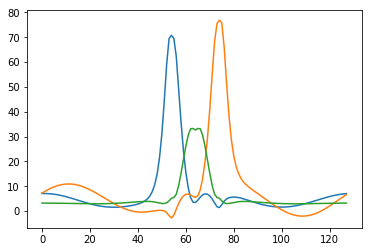

In [15]:
q = get_projected('data-density/coo/box-15/', (0, 1), 'OAC')[4]
for s in q:
    plt.plot(s)

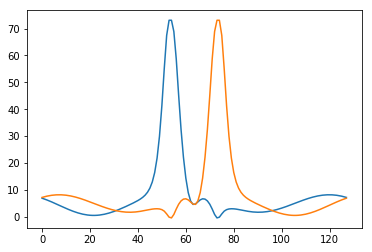

In [21]:
plt.plot((q[0]+q[1][::-1])/2)
plt.plot((q[0][::-1]+q[1])/2)
